To install a package, if it is not present, use the following command

!pip install packageName

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=b548a6fdf4170037c8864e3e2b536ca9efc6a0c1d316e3d226446492824f6eb2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


#Import Libraries

In [2]:
import os
import numpy as np
import cv2 
import wget 

create a directory and change the current director

In [3]:
!pwd  #present working directory

/content


In [4]:
rootDir='./Data'
os.makedirs(rootDir, exist_ok=True)    
        
os.chdir(rootDir)

In [5]:
!pwd

/content/Data


#Download dataset in current directory. For more info about dataset visit http://yann.lecun.com/exdb/mnist/

In [6]:
url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
wget.download(url)

url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
wget.download(url)

url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
wget.download(url)

url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
wget.download(url)

't10k-labels-idx1-ubyte.gz'

#Extract the training data and store it in Train folder

In [7]:
image_size = 28
import gzip

fx = gzip.open('train-images-idx3-ubyte.gz','r')
fx.read(16)
fy = gzip.open('train-labels-idx1-ubyte.gz','r')
fy.read(8)
count=0
while 1:
    labBuff=fy.read(1)
    if not labBuff:
        break
    label = np.frombuffer(labBuff, dtype=np.uint8)[0]
    buf = fx.read(image_size * image_size )
    data = np.frombuffer(buf, dtype=np.uint8)
    image = data.reshape(image_size, image_size)
    parentDir='Train'+os.sep+str(label)
    os.makedirs(parentDir, exist_ok=True)    
    cv2.imwrite(parentDir+os.sep+str(count)+'.png',image)  
    count += 1


#Extract the testing data and store it in Test folder

In [8]:
fx = gzip.open('t10k-images-idx3-ubyte.gz','r')
fx.read(16)
fy = gzip.open('t10k-labels-idx1-ubyte.gz','r')
fy.read(8)
count=0
while 1:
    labBuff=fy.read(1)
    if not labBuff:
        break
    label = np.frombuffer(labBuff, dtype=np.uint8)[0]
    buf = fx.read(image_size * image_size )
    data = np.frombuffer(buf, dtype=np.uint8)
    image = data.reshape(image_size, image_size)
    parentDir='Test'+os.sep+str(label)
    os.makedirs(parentDir, exist_ok=True)    
    cv2.imwrite(parentDir+os.sep+str(count)+'.png',image)  
    count += 1

#Create Training and Testing Dataset

In [10]:
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2 

print(os.getcwd())
rootDir='/'
os.chdir(rootDir)
!pwd

/
/


#Creat Train and Test datalist


In [11]:
rootDir='./content/Data/Train'
trainList=[]
for path, subdirs, files in os.walk(rootDir):
  for name in files:
    if not name.endswith('.png'):
        continue  
    
    imPath=os.path.join(path, name); 
    # print(imPath)
    parts=imPath.split(os.sep);   
    trainList.append([imPath, int(parts[-2])])
        
        
rootDir='./content/Data/Test'
testList=[]
for path, subdirs, files in os.walk(rootDir):
    for name in files:
        if not name.endswith('.png'):
            continue  
        
        imPath=os.path.join(path, name); 
        # print(imPath)
        parts=imPath.split(os.sep);   
        testList.append([imPath, int(parts[-2])])
  

#Creat MNIST Dataset

In [12]:
class create_mnist_dataset(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
    def gen(self,dataList, phase='Train'):
        inps=[]
        labels=[]
        try:
          while 1:
              shuffle(dataList)
              for imPath, label in dataList:
                  # print(imPath)
                  tmp=np.zeros((10),dtype='uint8')
                  tmp[int(label)]=1
                  labels.append(tmp.copy())
                  image=cv2.imread(imPath,0) ### we want to read image as gray
                  image.shape
                  inps.append(np.expand_dims(image,axis=-1))
                  if len(labels)==self.batch_size:            
                      yield np.asarray(inps,dtype='float32'), np.asarray(labels,dtype='float32')
                      inps=[]
                      labels=[]
              if phase=='Test':
                  break
        except GeneratorExit:
          print("Generated Finished")

batch_size=256
# print(len(trainList))
dataset=create_mnist_dataset(batch_size)
traindata=dataset.gen(trainList)

#Plot data

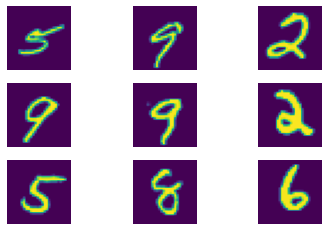

In [13]:
%matplotlib inline

testdata=dataset.gen(testList,phase='Test')
vimages, vclasses = next( testdata)

# Fill out the subplots with the random images that you defined 
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(vimages[i].reshape(28,28))
    plt.subplots_adjust(wspace=0.5)
plt.show()

#Initialize parameters

In [14]:
# Parameters
learning_rate = 0.01
training_iteration = 1000
display_step = 10


# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = [28,28,1] # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)


initializer=tf.keras.initializers.HeNormal()  
# initializer=tf.keras.initializers.HeUniform()
# initializer = tf.initializers.orthogonal(gain=1.0) 
# initializer = tf.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal')  
# initializer = tf.initializers.glorot_uniform()  
# initializer = tf.initializers.glorot_normal()  
# initializer = tf.initializers.RandomUniform(minval=-1.0, maxval=1.0)  
# initializer = tf.initializers.RandomNormal(mean=0, stddev=1.0)  

# Store layers weight & bias
weights = {
    'cnn1': tf.Variable(initializer([3,3,n_input[2],32]),trainable=True),
    'cnn2': tf.Variable(initializer([3,3,32,32]),trainable=True),
    
    
    'cnn3': tf.Variable(initializer([3,3,32,64]),trainable=True),
    'cnn4': tf.Variable(initializer([3,3,64,64]),trainable=True),    
    
    'cnn5': tf.Variable(initializer([3,3,64,64]),trainable=True),
                       
    'h1': tf.Variable(initializer([64*2*2, n_hidden_1]),trainable=True),
    'h2': tf.Variable(initializer([n_hidden_1, n_hidden_2]),trainable=True),
    'out': tf.Variable(initializer([n_hidden_2, n_classes]),trainable=True)
}
biases = {
    'cb1': tf.Variable(tf.zeros([32]),trainable=True),
    'cb2': tf.Variable(tf.zeros([32]),trainable=True),
    'cb3': tf.Variable(tf.zeros([64]),trainable=True),
    'cb4': tf.Variable(tf.zeros([64]),trainable=True),
    'cb5': tf.Variable(tf.zeros([64]),trainable=True),
    
    'b1': tf.Variable(tf.zeros([n_hidden_1]),trainable=True),
    'b2': tf.Variable(tf.zeros([n_hidden_2]),trainable=True),
    'out': tf.Variable(tf.zeros([n_classes]),trainable=True)
}

varList=[]
for key in weights:
  varList.append(weights[key])
for key in biases:
  varList.append(biases[key])           

#Create Model

In [15]:
# Create model
def multilayerNN(x):
    
    cnn1_out=tf.add( tf.nn.conv2d( x, weights['cnn1'], [1,1,1,1], padding='VALID'), biases['cb1'])
    cnn1_actv=tf.nn.leaky_relu(cnn1_out, alpha=0.2)
    
    cnn2_out=tf.add( tf.nn.conv2d( cnn1_actv, weights['cnn2'], [1,1,1,1], padding='VALID'), biases['cb2'])
    cnn2_actv=tf.nn.leaky_relu(cnn2_out, alpha=0.2)
    
    
    pool1=tf.nn.max_pool(cnn2_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    cnn3_out=tf.add( tf.nn.conv2d( pool1, weights['cnn3'], [1,1,1,1], padding='VALID'), biases['cb3'])
    cnn3_actv=tf.nn.leaky_relu(cnn3_out, alpha=0.2)
    cnn4_out=tf.add( tf.nn.conv2d( cnn3_actv, weights['cnn4'], [1,1,1,1], padding='VALID'), biases['cb4'])
    cnn4_actv=tf.nn.leaky_relu(cnn4_out, alpha=0.2)
    
    pool2=tf.nn.max_pool(cnn4_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    cnn5_out=tf.add( tf.nn.conv2d( pool2, weights['cnn5'], [1,1,1,1], padding='VALID'), biases['cb5'])
    cnn5_actv=tf.nn.leaky_relu(cnn5_out, alpha=0.2)
    
    
    flatten1=tf.reshape(cnn5_actv,(-1,64*2*2))


    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(flatten1, weights['h1']), biases['b1'])
    layer_1=tf.nn.leaky_relu(layer_1, alpha=0.2)
    #drop1=tf.nn.dropout(layer_1,rate=0.25)
    
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2=tf.nn.leaky_relu(layer_2, alpha=0.2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # out_layer=tf.nn.sigmoid(out_layer)
    y=tf.nn.softmax(out_layer,axis=-1)
    return y



optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=10.0**-7)
# optimizer = tf.keras.optimizers.SGD( learning_rate=learning_rate, momentum=0.0)

#Train Model

In [16]:
iteration=0
while iteration<training_iteration:
  iteration = iteration + 1 
  images, classes = next(traindata)
       
  images=tf.convert_to_tensor(images)
  images=(images-127.5)/127.5
  classes=tf.convert_to_tensor(classes)
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(varList)
    y = multilayerNN(images)

    loss = tf.reduce_mean(-classes*tf.math.log(y) )

  gradients = tape.gradient(loss, varList)
  optimizer.apply_gradients(zip(gradients, varList))

  
  # Display loss per epoch step
  if iteration % display_step == 0:
      print("iteration:", '%04d' % (iteration), "cost={:.9f}".format(loss))

iteration: 0010 cost=0.414237887
iteration: 0020 cost=0.368024528
iteration: 0030 cost=0.314102799
iteration: 0040 cost=0.271147549
iteration: 0050 cost=0.247635201
iteration: 0060 cost=0.231773093
iteration: 0070 cost=0.216648266
iteration: 0080 cost=0.203563422
iteration: 0090 cost=0.201014563
iteration: 0100 cost=0.194190279
iteration: 0110 cost=0.185700506
iteration: 0120 cost=0.181561664
iteration: 0130 cost=0.184048682
iteration: 0140 cost=0.176543429
iteration: 0150 cost=0.163267851
iteration: 0160 cost=0.147754028
iteration: 0170 cost=0.145302474
iteration: 0180 cost=0.144402057
iteration: 0190 cost=0.143876225
iteration: 0200 cost=0.141242459
iteration: 0210 cost=0.127219990
iteration: 0220 cost=0.130730033
iteration: 0230 cost=0.115070209
iteration: 0240 cost=0.119232692
iteration: 0250 cost=0.109741054
iteration: 0260 cost=0.107259512
iteration: 0270 cost=0.105081640
iteration: 0280 cost=0.101309277
iteration: 0290 cost=0.092346407
iteration: 0300 cost=0.099008910
iteration:

# **Testing**

In [17]:
print(len(testList))
testdata=dataset.gen(testList,phase='Test')

totalN=0
totalP=0
while True:
  try:
    images, classes = next(testdata)
  except:
    break
  # print(classes)
  images=tf.convert_to_tensor(images)
  images=(images-127.5)/127.5
  classes=tf.convert_to_tensor(classes)
  y = multilayerNN(images)
  yclass=tf.argmax(y,axis=-1)
  classes=tf.argmax(classes,axis=-1)

  p=tf.reduce_sum(tf.cast( tf.equal(yclass,classes), dtype='float32'))
  totalP = totalP + p
  totalN = totalN + batch_size

  if iteration % display_step == 0:
      print("totalN:", '%04d' % (totalN), "totalP:", '%04d' % (totalP), "Accuracy={:.9f}".format(totalP*100/totalN))

10000
Generated Finished
totalN: 0256 totalP: 0237 Accuracy=92.578125000
totalN: 0512 totalP: 0466 Accuracy=91.015625000
totalN: 0768 totalP: 0697 Accuracy=90.755210876
totalN: 1024 totalP: 0928 Accuracy=90.625000000
totalN: 1280 totalP: 1156 Accuracy=90.312500000
totalN: 1536 totalP: 1383 Accuracy=90.039062500
totalN: 1792 totalP: 1614 Accuracy=90.066963196
totalN: 2048 totalP: 1840 Accuracy=89.843750000
totalN: 2304 totalP: 2063 Accuracy=89.539932251
totalN: 2560 totalP: 2289 Accuracy=89.414062500
totalN: 2816 totalP: 2525 Accuracy=89.666191101
totalN: 3072 totalP: 2759 Accuracy=89.811195374
totalN: 3328 totalP: 2991 Accuracy=89.873794556
totalN: 3584 totalP: 3229 Accuracy=90.094863892
totalN: 3840 totalP: 3469 Accuracy=90.338539124
totalN: 4096 totalP: 3702 Accuracy=90.380859375
totalN: 4352 totalP: 3930 Accuracy=90.303306580
totalN: 4608 totalP: 4163 Accuracy=90.342880249
totalN: 4864 totalP: 4404 Accuracy=90.542762756
totalN: 5120 totalP: 4637 Accuracy=90.566406250
totalN: 5376 to

In the first notebook, where we used FNN got very poor performance. But using CNN network we can see a great improvement in accuracy. This is because CNN is able to capture the spatial ralation of image pixels values.

--------------------